In [1]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
import model_conv
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5


In [3]:
print(os.getcwd())

/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src


In [4]:
param_file = '../../../cellbgnet/utils/reference_files/reference_Axel.yaml'
param = cellbgnet.utils.param_io.ParamHandling().load_params(param_file)


In [5]:
psf_params = param.PSF.to_dict()
simulation_params = param.Simulation.to_dict()
hardware_params = param.Hardware.to_dict()
train_size = simulation_params['train_size']
calib_file = psf_params['calib_file']


In [6]:
psf_size = 41
xextent = [-0.5, 127.5]
yextent = [-0.5, 127.5]
zextent = [-400, 400]
scale = torch.tensor([(xextent[1] - xextent[0]),
                      (yextent[1] - yextent[0]),
                      (zextent[1] - zextent[0])])
shift = torch.tensor([xextent[0], yextent[0], zextent[0]])



In [7]:
psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 63.5], yextent=[-0.5, 63.5], img_shape=[64, 64], device='cuda', 
roi_size=None, roi_auto_center=None, normalize=True)


INITIATING CUDA IMPLEMENTATION


In [8]:
epochs = 40
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [10]:
# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

In [11]:
def create_psf_batch(size=64, batch_size=64):
    xyz = torch.normal(float(size/2), float(size/4), (batch_size,3))
    xyz[:, 2] = 0.0
    xyz = xyz.view(1, -1, 3)
    photon_scale = 100
    #photons = torch.rand((xyz.shape[1], 1))*photon_scale
    photons = torch.ones((xyz.shape[1], 1))*photon_scale
    frames = torch.cat([psf.forward(xyz[:,i,...], photons[i]) for i in range(xyz.shape[1])])
    frames = frames.view(frames.shape[0],1,frames.shape[1], frames.shape[2])
    return frames, xyz, photons


In [12]:
frames,_, _ = create_psf_batch()

In [13]:
def create_batch(size=28, batch_size=64):
    batch = torch.zeros([batch_size,1,size,size])
    xys = torch.tensor([[0], [0]])
    xs = torch.randint(0, size, (batch_size,))
    ys = torch.randint(0, size,  (batch_size,))
    xys = torch.concatenate([xs.view(-1,1), ys.view(-1,1)], dim=1)
    batch[torch.arange(batch.shape[0]),0, xs, ys] = 1
    return batch, xys

In [20]:
#model = model.LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')


In [15]:
model = torch.load("/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_PSF_1.pt")


In [16]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    A beta here will affect how much the KLD matters

    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [17]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i in range((28*28)//batch_size):
        data = create_psf_batch()
        data, xyz, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = running_loss/784
    return train_loss

In [18]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i in range((28*28)//batch_size):
            data = create_psf_batch()
            data, xys, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if ((28*28)//batch_size - 1) and (epoch % 100 == 0):
                #plt.imshow(data.view(batch_size, 1, 64, 64)[0,0,...].cpu().detach().numpy(), cmap='gray')
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 64, 64)[:8], 
                                  reconstruction.view(batch_size, 1, 64, 64)[:8]))
                save_image(both.cpu(), f"../outputs/psf_output{epoch}.png", nrow=num_rows)

    val_loss = running_loss/784
    return val_loss, mu, xys

In [208]:
#train_loss = []
#val_loss = []
curr = 27928
for epoch in range(curr, curr+6001):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, 0)
    val_epoch_loss, mu, xys = validate(model, 0)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 24135 of 40
Train Loss: -1.9555
Val Loss: -11.3096
Epoch 24136 of 40
Train Loss: -1.3958
Val Loss: -13.3972
Epoch 24137 of 40
Train Loss: -2.4355
Val Loss: -12.6406
Epoch 24138 of 40
Train Loss: -6.6642
Val Loss: -2.8655
Epoch 24139 of 40
Train Loss: -2.5793
Val Loss: -3.9554
Epoch 24140 of 40
Train Loss: -4.3533
Val Loss: -4.1953
Epoch 24141 of 40
Train Loss: -3.0806
Val Loss: 2.3097
Epoch 24142 of 40
Train Loss: -10.1308
Val Loss: -11.0286
Epoch 24143 of 40
Train Loss: -1.0995
Val Loss: -7.6071
Epoch 24144 of 40
Train Loss: -5.8998
Val Loss: -7.2091
Epoch 24145 of 40
Train Loss: 3.4811
Val Loss: -23.9779
Epoch 24146 of 40
Train Loss: -8.5113
Val Loss: -3.1197
Epoch 24147 of 40
Train Loss: -12.0704
Val Loss: -9.0255
Epoch 24148 of 40
Train Loss: -3.8621
Val Loss: -18.9944
Epoch 24149 of 40
Train Loss: -8.0345
Val Loss: -14.3934
Epoch 24150 of 40
Train Loss: -12.4558
Val Loss: 1.5792
Epoch 24151 of 40
Train Loss: -10.8588
Val Loss: -16.6444
Epoch 24152 of 40
Train Loss: -8.9244
V

KeyboardInterrupt: 

In [209]:
torch.save(model, "/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_PSF_1.pt")
torch.save(model.state_dict(), "/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_PSF_1_sd.pt")

In [117]:

i = 3
print((mu[i,:]*32)+32)
print(xys[0,i,:])
# Måste generera pricka kontinuerligt annars lär den sig nog bara

tensor([-89.0924,  39.4680], device='cuda:0')
tensor([45.5582, 46.3927,  0.0000])


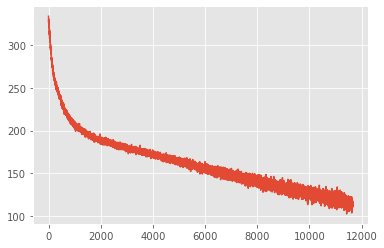

In [118]:
plt.plot(list(range(len(train_loss))), train_loss)


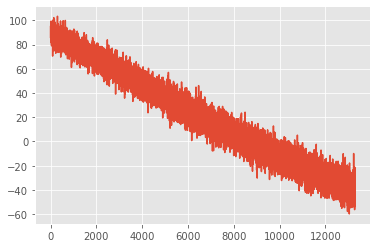

In [210]:
plt.plot(list(range(len(train_loss))), train_loss)


In [122]:
x = xys[0,0]
y = xys[0,1]

In [211]:
images, xys, _ = create_psf_batch(batch_size=40000)
model.eval()
images = images.to(device)
reconstruction, mu, logvar = model(images.view(images.size(0), -1))


In [212]:
yin = (xys[0,:,1]>-1) & (xys[0,:,1]<64)
xin = (xys[0,:,0]>-1) & (xys[0,:,0]<64)
both_in = xin&yin
both_in

tensor([ True,  True,  True,  ...,  True, False,  True])

In [213]:
predicted = mu[both_in,0].cpu().detach().numpy()
x = xys[0,both_in,1]

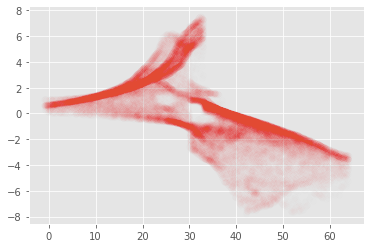

In [214]:
plt.plot(x, predicted, 'o', alpha=0.005)


In [215]:
predicted = mu[both_in,1].cpu().detach().numpy()
x = xys[0,both_in,0]


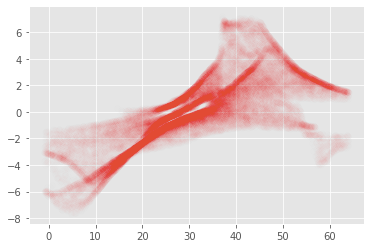

In [216]:
plt.plot(x, predicted, 'o', alpha=0.005)


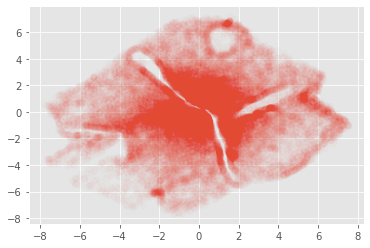

In [217]:
plt.plot(mu[:,0].cpu().detach().numpy(), mu[:,1].cpu().detach().numpy(), 'o', alpha=0.01)

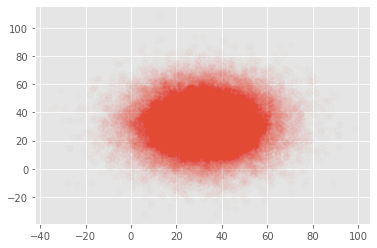

In [218]:
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.plot(xys[0,:,0].cpu().detach().numpy(), xys[0,:,1].cpu().detach().numpy(), 'o', alpha=0.01)


In [96]:
for x in range(0,10):
    x = x/10
    z = torch.tensor([x,0.0]).to(device);
    x = F.relu(model.dec1(z));
    test = torch.sigmoid(model.dec2(x));

    plt.imshow(test.view([28,28]).cpu().detach().numpy(), cmap='gray');
    plt.title(x);
    plt.show();

type: shape '[28, 28]' is invalid for input of size 4096

In [ ]:
#both = torch.cat((data.view(batch_size, 1, 64, 64)[:8], 
                    reconstruction.view(batch_size, 1, 64, 64)[:8]))
#save_image(both.cpu(), f"../outputs/psf_output{epoch}.png", nrow=num_rows)


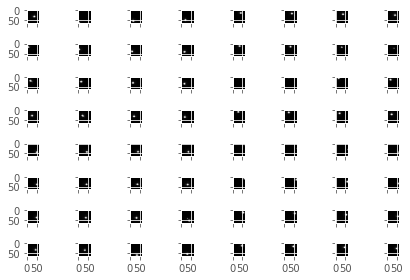

In [144]:
model.eval()
fig, axs = plt.subplots(8,8, sharex=True, sharey=True)
# decoding
fig.tight_layout()
for i in range(-4,4):
    for j in range(-4,4):
        z = torch.tensor([[float(i),float(j)]]).cuda()
        axs[i,j].imshow(reconstruction.view((64, 64)).cpu().detach().numpy(), cmap='gray')

plt.show()


In [137]:
reconstruction.view((64, 64))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0368e-01, 3.2587e-01,
         2.6970e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.7344e-01, 4.9652e-01,
         3.5723e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.4673e-01, 8.1915e-01,
         6.0063e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4258e-36, 3.9615e-36,
         4.5398e-36],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.4501e-39, 7.5286e-39,
         5.2027e-39],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0', grad_fn=<ViewBackward0>)

type: module 'torch' has no attribute 'repeat'

In [199]:
mus = torch.cat((torch.arange(-6,7).repeat(13).view(-1,1),torch.arange(-6,7).repeat_interleave(13).view(-1,1)),1)

In [201]:
model.eval()
z = mus.float().cuda()
x = F.relu(model.dec1(z))
reconstruction = torch.sigmoid(model.dec2(x))


In [206]:
save_image(reconstruction.view((13*13, 1, 64,64)).cpu(), f"../outputs/test_values.png", nrow=13, pad_value=1)

In [204]:
reconstruction.shape

torch.Size([169, 4096])

tensor([[-6., -6.],
        [-5., -6.],
        [-4., -6.],
        [-3., -6.],
        [-2., -6.],
        [-1., -6.],
        [ 0., -6.],
        [ 1., -6.],
        [ 2., -6.],
        [ 3., -6.],
        [ 4., -6.],
        [ 5., -6.],
        [ 6., -6.],
        [-6., -5.],
        [-5., -5.],
        [-4., -5.],
        [-3., -5.],
        [-2., -5.],
        [-1., -5.],
        [ 0., -5.],
        [ 1., -5.],
        [ 2., -5.],
        [ 3., -5.],
        [ 4., -5.],
        [ 5., -5.],
        [ 6., -5.],
        [-6., -4.],
        [-5., -4.],
        [-4., -4.],
        [-3., -4.],
        [-2., -4.],
        [-1., -4.],
        [ 0., -4.],
        [ 1., -4.],
        [ 2., -4.],
        [ 3., -4.],
        [ 4., -4.],
        [ 5., -4.],
        [ 6., -4.],
        [-6., -3.],
        [-5., -3.],
        [-4., -3.],
        [-3., -3.],
        [-2., -3.],
        [-1., -3.],
        [ 0., -3.],
        [ 1., -3.],
        [ 2., -3.],
        [ 3., -3.],
        [ 4., -3.],
